<a href="https://colab.research.google.com/github/SofiMich/CE/blob/main/T5_CE_Michaelian_Bloat_Neutralidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import random

In [ ]:
def sum(x, y):
  return x + y

def times(x, y):
  return x * y

functions1 = {
  '+': sum
}

functions2 = {
  '+': sum,
  '*': times
}

arguments = {
  '+': 2,
  '*': 2
}

terminals = {
  '0' : 0,
  '1' : 1,
  '4' : 4
}

objetivo = 10


In [ ]:
def seleccionarOp(individuo, nNodos,  nMaxNodos, nFunc, nMaxFunc, nArg, listaFunc, listaTerms):
  if ((nNodos <= nMaxNodos) and (nArg > 0)):
    #print(nNodos)
    r = random.randint(1,10)
    #print(r)

    if ((r <= 5) and (nFunc <= nMaxFunc)):
      #print('Seleccionando función')
      token = np.random.choice(listaFunc)
      nArg = nArg + arguments[token]
      nFunc = nFunc + 1
      
    else:
      #print('Seleccionando terminal')
      token = np.random.choice(listaTerms)

    nNodos = nNodos + 1
    nArg = nArg - 1
    individuo.append(token)
    #print(nNodos, token, nArg)

    if ((nNodos <= nMaxNodos) and (nArg > 0)):
      seleccionarOp(individuo, nNodos,  nMaxNodos, nFunc, nMaxFunc, nArg, listaFunc, listaTerms)
    
  return individuo

In [ ]:
def crearIndividuo(nMaxNodos, listaFunc, listaTerms):
  individuo = []
  nMaxFunc = nMaxNodos/2 - 1
  nNodos = 0
  nFunc = 0
  nArg = 1
  indivuduo = seleccionarOp(individuo, nNodos,  nMaxNodos, nFunc, nMaxFunc, nArg, listaFunc, listaTerms)
  l = len(individuo)
  n = nMaxNodos - len(individuo)
  ceros = ['0']*n
  individuo = individuo + ceros
  return individuo, l

In [ ]:
def parse(tokens, terminals, functions):
  if (len(tokens)) > 0:
    token = tokens.pop(0)
    if token in functions:
        if arguments[token] == 1:
          return functions[token](parse(tokens, terminals, functions))
        elif arguments[token] == 2:
          return functions[token](parse(tokens, terminals, functions), parse(tokens, terminals, functions))
    else:
        return terminals[token]
  else:
    return 0

In [ ]:
def crearPoblacion(listaFunc, listaTerms, nInd = 50, nMaxNodos = 16):
  pob = []
  l = []
  for i in range(nInd):
    individuo, l = crearIndividuo(nMaxNodos, listaFunc, listaTerms)
    pob.append([individuo, l, 0])
  return pob

In [ ]:
def evaluarIndividuo(individuo, objetivo, functions, terminales):
  #print('evaluando')
  error = 0
  y_expected = objetivo

  l = individuo[1]
    
  if l > 0:
    tokens = individuo[0][0:l]
    y = parse(tokens, terminales, functions)
  else:
    y = 0
  error = (error + abs(y-y_expected))/objetivo
  individuo[-1] = error

  return individuo, error

In [ ]:

def evaluarPoblacion(pob, objetivo, functions, terminales):
  x = np.zeros(len(pob))
  for i in range(len(pob)):
    pob[i], x[i] = evaluarIndividuo(pob[i], objetivo, functions, terminales)
  return pob, x

### Calcular Fitness

In [ ]:
def calcularFitness(pob):
  total = np.sum(pob, axis = 0)[-1]
  for i in range(len(pob)):
    pob[i][-1] = pob[i][-1] / (total + np.nextafter(0,1))
  return pob

### Calcular probabilidad de selección

In [ ]:
def calcularPS(x):
  total = np.sum(x, axis = 0)[-1]
  
  for i in x:
    if i[-1]/total >= 0:
        i[-1] = i[-1]/total
    else:
        print('Probabilidad negativa!!!')
        print(i)
        i[-1] = np.nextafter(0,1)
  return x

### Seleccionar individuos para el pool de cruza

In [ ]:
def seleccionar(pob): # Calcular las probabilidades se puede omitir si usamos torneo u otro método
  pool = []
  proba = np.zeros(len(pob))
  for i in range(len(pob)):
    proba[i] = pob[i][-1]
    
  for i in range(len(pob)):
    r = np.random.choice(range(len(pob)), p = proba)
    pool.append(pob[r][0:2])
  return pool

### Cruza

In [ ]:
def cruzar(pool, pc):
  nuevaGen = []

  l = len(pool[0][0])

  for i in range(len(pool)//2):
    
    padre1 = pool[2*i][0]
    l1 = pool[2*i][1]

    padre2 = pool[2*i+1][0]
    l2 = pool[2*i][1]

    r = random.uniform(0,1)

    if r <= pc:

      n1 = random.randint(0,l1-1)
      n2 = random.randint(0,l2-1)
      
      f1 = n1+(l2-n2)
      f2 = n2+(l1-n1)

      if (f1 <= l) and (f2 <= l):

        ceros = ['0']*(l-f1)
        hijo1 = padre1[0:n1]+padre2[n2:l2]+ceros

        ceros = ['0']*(l-f2)
        hijo2 = padre2[0:n2]+padre1[n1:l1]+ceros

      else:
        hijo1 = padre1
        hijo2 = padre2
        f1 = l1
        f2 = l2
    
    else:
      hijo1 = padre1
      hijo2 = padre2
      f1 = l1
      f2 = l2

    nuevaGen.append([hijo1, f1, 0])
    nuevaGen.append([hijo2, f2, 0])

  return nuevaGen
    

### Mutación

In [ ]:
def mutar(nuevaGen, listaFunc, listaTerms, pm = 1):
  l = len(nuevaGen[0][0])

  for i in range(len(nuevaGen)):
    prob = random.uniform(np.nextafter(0,1),1.0)
    if prob <= pm:
      l1 = nuevaGen[i][1]
      n = random.randint(0,l1)
      mutacion = crearIndividuo(l-n, listaFunc, listaTerms)
      nuevaGen[i][0] = nuevaGen[i][0][0:n] + mutacion[0]
      nuevaGen[i][1] = n + mutacion[1]
  return nuevaGen

# Contar 0s, 1s y 4s

In [ ]:
def contar(token, tokens):
  if (len(tokens)) > 0:
    res = tokens.count(token)
    return res
  else:
    return 0

In [ ]:
def contarIndividuo(individuo, token):
  l = individuo[1]
  if l > 0:
    tokens = individuo[0][0:l]
    y = contar(token, tokens)
  else:
    y = 0

  return y

In [ ]:
def contarPoblacion(pob, token):
  x = 0
  for i in range(len(pob)):
    x = x + contarIndividuo(pob[i], token)
  return x#/len(pob)

# Evolucionar

In [ ]:
def evolucionar(nInd, nMaxNodos, ngeneraciones, pc, pm, objetivo, functions, terminals, nombre):
  
  cuentas = np.zeros((ngeneraciones,3))
  mejor = []  
  promedio = np.zeros(ngeneraciones)

  listaFunc = list(functions.keys())
  listaTerms = list(terminals.keys())

  pob = crearPoblacion(listaFunc, listaTerms, nInd , nMaxNodos)

  for i in range(ngeneraciones):

    #print(i)
    pob, x = evaluarPoblacion(pob, objetivo, functions, terminals)

    indMin = np.where(x == np.min(x))[0][0]
    
    #print(np.where(x == np.min(x))[0][0])
    mejor.append(pob[indMin]) #guardamos al individuo con el mejor desempeño
  
    promedio[i] = np.sum(x) / len(pob) #calculamos el promedio del desempeño de la población
 
    pob = calcularFitness(pob)

    pool = seleccionar(pob)

    nuevaGen = cruzar(pool, pc)

    nuevaGen = mutar(nuevaGen, listaFunc, listaTerms, pm)

    #Elitismo:
    k = np.random.randint(0,len(pob))
    #print(k,i)
    #print(mejor)
    retadores = nuevaGen
    retadores, y = evaluarPoblacion(retadores, objetivo, functions, terminals)
    indMax = np.where(y == np.max(y))[0][0]

    nuevaGen[indMax] = mejor[i]
    #print(mejor[i])

    # CUENTAS
    for t in range(len(listaTerms)):
      token = listaTerms[t]
      cuentas[i,t] = contarPoblacion(pob, token)
    
    pob = nuevaGen


# Graficar
  import matplotlib.pyplot as plt

  plt.axes(xlabel='Generación', ylabel = 'Error')
  plt.title('Desempeño ' + str(nInd) + ' individuos en ' +str(ngeneraciones) + ' generaciones\n'+ nombre)

  mejores, y = evaluarPoblacion(mejor, objetivo, functions, terminals)
  plt.plot(promedio)
  plt.plot(y)
  #print(y)

  plt.legend(labels=["Promedio","Mejor individuo"])
  plt.show()


  plt.axes(xlabel='Generación', ylabel = '#')
  plt.title(str(nInd) + ' individuos en ' +str(ngeneraciones) + ' generaciones\n'+ nombre)

  plt.plot(cuentas[:,0], label = '0')
  plt.plot(cuentas[:,1], label = '1')
  plt.plot(cuentas[:,2], label = '4')

  plt.legend()
  plt.show()

  return mejores, cuentas


In [ ]:
def evolucionarTorneo(nInd, nMaxNodos, ngeneraciones, pc, pm, objetivo, functions, terminals, nombre):
  
  cuentas = np.zeros((ngeneraciones,3))

  mejor = []  
  promedio = np.zeros(ngeneraciones)

  listaFunc = list(functions.keys())
  listaTerms = list(terminals.keys())

  pob = crearPoblacion(listaFunc, listaTerms, nInd, nMaxNodos)

  for i in range(ngeneraciones):

    pob, x = evaluarPoblacion(pob, objetivo, functions, terminals)

    indMin = np.where(x == np.min(x))[0][0]
    
    mejor.append(pob[indMin]) #guardamos al individuo con el mejor desempeño
  
    promedio[i] = np.sum(x) / len(pob) #calculamos el promedio del desempeño de la población
 
    pob = calcularFitness(pob)

    pool = seleccionar(pob)

    nuevaGen = cruzar(pool, pc)
    
    nuevaGen = mutar(nuevaGen, listaFunc, listaTerms, pm)

    #Elitismo total
    torneo = pob + nuevaGen
    torneo, y = evaluarPoblacion(torneo, objetivo, functions, terminals)
    indMin = np.argpartition(y, nInd) 
    j = 0
    for k in range(nInd):
      nuevaGen[k] = (np.array(torneo, dtype=object)[indMin.astype(int)][j]).tolist()
      j = (j + 1)% nInd

     # CUENTAS
    for t in range(len(listaTerms)):
      token = listaTerms[t]
      cuentas[i,t] = contarPoblacion(pob, token)
      #print(cuentas[i,t])
    
    pob = nuevaGen

# Graficar
  import matplotlib.pyplot as plt

  plt.axes(xlabel='Generación', ylabel = 'Error')
  plt.title('Desempeño ' + str(nInd) + ' individuos en ' +str(ngeneraciones) + ' generaciones\n'+ nombre)

  mejores, y = evaluarPoblacion(mejor, objetivo, functions, terminals)
  plt.plot(promedio)
  plt.plot(y)

  plt.legend(labels=["Promedio","Mejor individuo"])
  plt.show()

  plt.axes(xlabel='Generación', ylabel = '#')
  plt.title(str(nInd) + ' individuos en ' +str(ngeneraciones) + ' generaciones\n'+ nombre)

  plt.plot(cuentas[:,0], label = '0')
  plt.plot(cuentas[:,1], label = '1')
  plt.plot(cuentas[:,2], label = '4')

  plt.legend()
  plt.show()

  return mejores, cuentas


#1. +


In [ ]:
nGen = 500
nInd = 100
pc = 0.9
pm = 0.05
nMaxNodos = 100
objetivo = 10

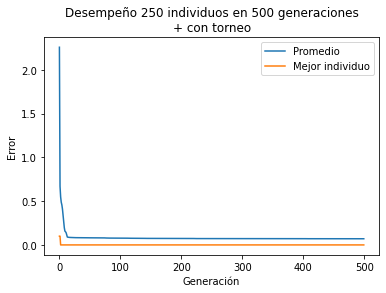

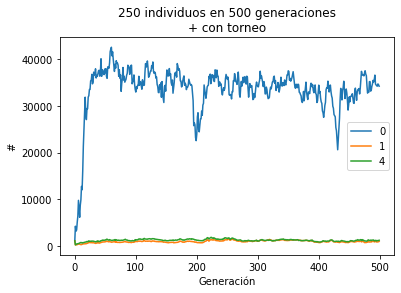

In [ ]:
mejores1, cuentas1 = evolucionarTorneo(nInd, nMaxNodos, nGen, pc, pm, objetivo, functions1, terminals, '+ con torneo')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


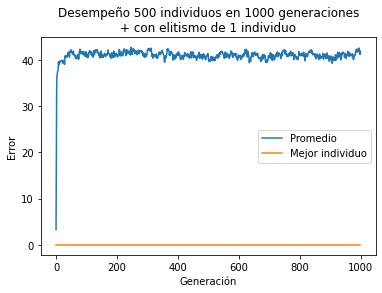

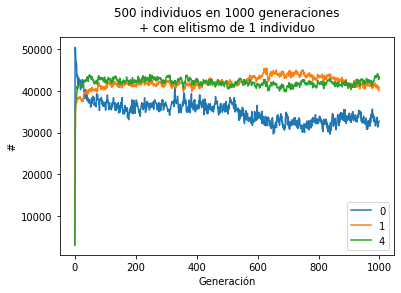

In [ ]:
mejores, cuentas1 = evolucionar(nInd, nMaxNodos, nGen, pc, pm, objetivo, functions1, terminals, '+ con elitismo de 1 individuo')

# 2. + *

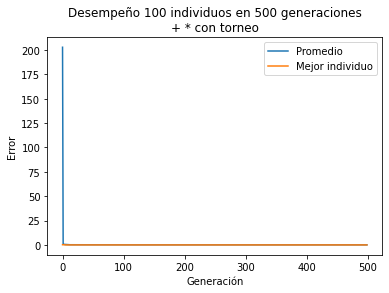

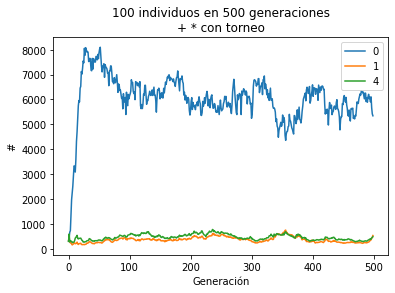

In [ ]:
mejores2, cuentas2 = evolucionarTorneo(nInd, nMaxNodos, nGen, pc, pm, objetivo, functions2, terminals, '+ * con torneo')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


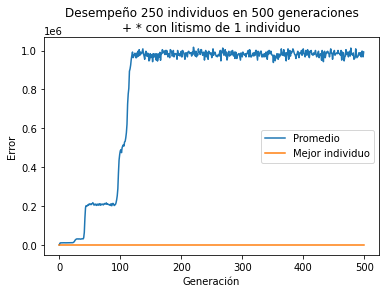

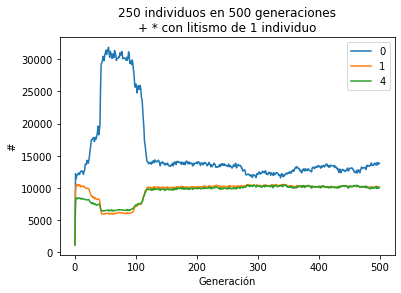

In [ ]:
mejores, cuentas2 = evolucionar(nInd, nMaxNodos, nGen, pc, pm, objetivo, functions2, terminals, '+ * con litismo de 1 individuo')